# PCA LAB.2 Solutions

In this lab we implement PCA. First of all let's import the useful modules.

In [1]:
import numpy as np  # linear algebra
import matplotlib.pyplot as plt # plotting
import pandas as pd # csv manipulation
from sklearn.model_selection import train_test_split # for train test split
from sklearn.linear_model import LogisticRegression # for classification
from sklearn.preprocessing import OrdinalEncoder # for preprocessing

## Exercise 1

The PCA is implemented as a class, following the same schema as `scikit-learn`.

In [2]:
class PCA(object):
    
    def __init__(self):
        
        self.eigenvalues = None
        self.transformation_matrix = None
        self._mean = None
    
    def fit(self, x):
                
        # centered data
        self._mean = np.mean(x, axis=0)
        x_c = x - self._mean
        
        # compute covariance matrix (X^t X)/n_samples
        conv_matrix = np.dot(x_c.T, x_c) / x.shape[0]
        self.conv = conv_matrix
        
        # decompose the matrix
        eigvalues, eigvects = np.linalg.eig(conv_matrix)
        
        # sort in ascending order
        idx = eigvalues.argsort()[::-1]   
        self.eigenvalues = eigvalues[idx]
        self.transformation_matrix = eigvects[:,idx]
        
    def transform(self, x, numb_components = None, eigen = False):
        
        # centered data
        x_c = x - self._mean
        
        # check consistency number of components
        numb_components = self._check_numb_components(x_c, numb_components)
        
        # choose the eigenvect/eigenval according to the number of components
        eigvalues = self.eigenvalues[:numb_components]
        transform_matrix = self.transformation_matrix[:, :numb_components]
        
        # project data
        projection = np.dot(x, transform_matrix)
        
        if eigen:
            return projection, eigen
        
        return projection
    
    def inverse_transform(self, y):
        # number of samples and features
        n_samples, n_features = y.shape
        # define tranformation matrix
        transform_matrix = self.transformation_matrix[:, :n_features]
        # return transformation + the mean vector
        return np.dot(y, transform_matrix.T) + self._mean
    
    def _check_numb_components(self, x, numb_components):
        """
        Expect input shape to be numb_sample X dimension_sample. 
        """
        # number of samples and features
        n_samples, n_features = x.shape
        
        # check consistency
        if numb_components is None:
            numb_components = n_features
            
        if numb_components < 1 or numb_components > n_features:
            raise ValueError("numb_components must be greater or equal than one"
                             " and smaller or equal to the number of features")
            
        return numb_components

Once the class is defined we can proceede with the exercise

In [3]:
# get the dataframe
df = pd.read_excel('../Datasets/Dry_Bean_Dataset.xlsx')

# create matrix for data in numpy ndarray
y = df['Class']
X = df.drop('Class', axis=1)
encoder = OrdinalEncoder()
y = np.array(y)
encoder.fit(y.reshape(-1, 1))
y = encoder.transform(y.reshape(-1, 1))

# split train test set
X_train, X_test, target_train, target_test = train_test_split(X, y, test_size=0.2)

# normilize
X_train = (X_train - X_train.mean())/(X_train.std())


Let's perform PCA on the training set

In [4]:
# initialize pca
pca = PCA()
# fit the train set
pca.fit(X_train)

Let's plot the eigenvalue spectrum, and see the total variance explained

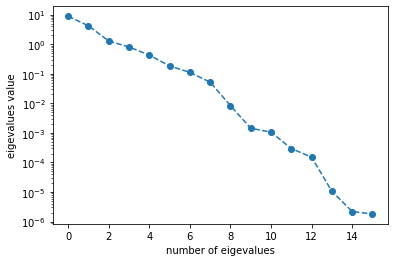

In [6]:
# plot
plt.semilogy(range(len(pca.eigenvalues)), pca.eigenvalues, '--o')
plt.xlabel('number of eigevalues')
plt.ylabel('eigevalues value')
plt.show()

From the graph one could choose 2 active components since they already explain most of the variance in the data

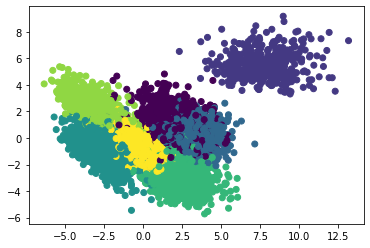

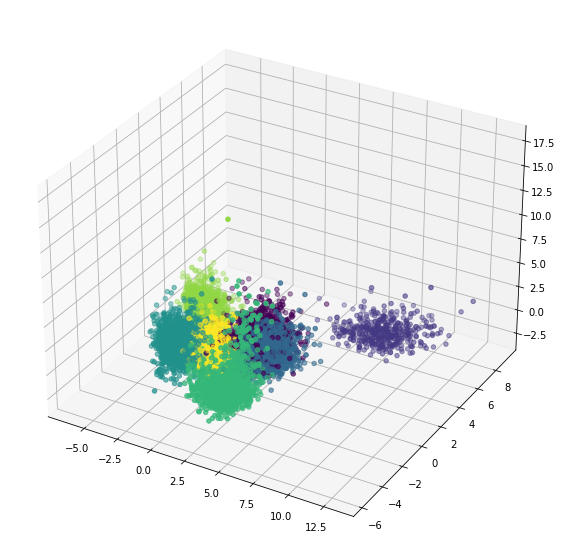

In [7]:
# project data
y = pca.transform(X_train, numb_components=2)

# plot data 2d
plt.scatter(y[:, 0], y[:, 1], c=target_train)
plt.show()

# project data
y = pca.transform(X_train, numb_components=3)

# plot data 3d
plt.figure(figsize=(12,10))
axes = plt.axes(projection='3d')
axes.scatter3D(y[:, 0], y[:, 1], y[:, 2], c=target_train)
plt.show()

Let's build two simple function for training and testing the model

In [8]:
def preprocess_data_by_PCA(X_train):
    # pca reduction
    pca = PCA()
    pca.fit(X_train)
    return pca
    
def train_model(y_train, target_train):
        
    # multinomial logistic regression
    model = LogisticRegression(multi_class='multinomial', max_iter=1000)
    model.fit(y_train, target_train)
    
    return model

def test_model(model, y_test, target_test):
    
    # compute target by model
    target_hat = model.predict(y_test)

    # compute score
    score = model.score(y_test, target_test)
    
    return score

#suppress warnings
import warnings
warnings.filterwarnings("ignore")

Let's see the model output for different number of components

In [9]:
# normalize
X_test = (X_test - X_test.mean())/X_test.std()

# preprocess data
pca = preprocess_data_by_PCA(X_train)

# for each component 
for numb_components in range(1, X.shape[1]+1):
    # training
    y_train = pca.transform(X_train, numb_components)
    model = train_model(y_train, target_train)
    
    # test
    y_test = pca.transform(X_test, numb_components)
    score = test_model(model, y_test, target_test)
    
    print(f"Number of components: {numb_components}/ Accuracy: {score}")

Number of components: 1/ Accuracy: 0.6360631656261476
Number of components: 2/ Accuracy: 0.8688946015424165
Number of components: 3/ Accuracy: 0.8802791039294895
Number of components: 4/ Accuracy: 0.8931325743665075
Number of components: 5/ Accuracy: 0.9265515975027543
Number of components: 6/ Accuracy: 0.9280205655526992
Number of components: 7/ Accuracy: 0.9294895336026442
Number of components: 8/ Accuracy: 0.9291222915901579
Number of components: 9/ Accuracy: 0.9287550495776716
Number of components: 10/ Accuracy: 0.9287550495776716
Number of components: 11/ Accuracy: 0.9287550495776716
Number of components: 12/ Accuracy: 0.9287550495776716
Number of components: 13/ Accuracy: 0.9287550495776716
Number of components: 14/ Accuracy: 0.9287550495776716
Number of components: 15/ Accuracy: 0.9287550495776716
Number of components: 16/ Accuracy: 0.9287550495776716


## Exercise 2

We switch now to a different excersies plotting the swiss roll

In [10]:
def swiss_roll(n):
    data = np.zeros((n,3))
    phi = np.random.uniform(low=1.5*np.pi, high=4.5*np.pi, size=n)
    psi = np.random.uniform(0,10,n)
            
    data[:,0]=phi*np.cos(phi) #x coordinte
    data[:,1]=phi*np.sin(phi) #y coordinate
    data[:,2]=psi #z coordinate
    return data


Let's visualize some data.

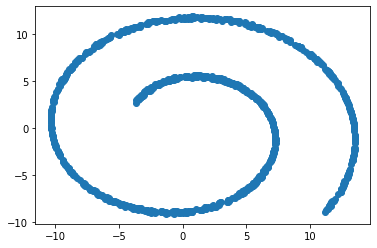

In [11]:
# get the data
data = swiss_roll(1000)

# perform pca
pca = PCA()
pca.fit(data)
y = pca.transform(data, 2)

# plot the results
plt.scatter(y[:, 0], y[:, 1])
plt.show()


As we can see, the PCA which is a linear dimensionality reduction technique, is not able to find the correct decomposition.